<a href="https://colab.research.google.com/github/JASONZ777/senti_analysis_Prompt_BERT_LoRA/blob/main/lora_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Method 3： LoRA-tuning

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/MyDrive/sentiment-analysis')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torch.utils.data import Dataset

class upload_dataset(Dataset):
    def __init__(self, data_file):
        self.data = self.load_data(data_file)

    def load_data(self, data_file):
        Data = {}
        with open(data_file, 'rt', encoding='utf-8') as f:
            for idx, line in enumerate(f):
                items = line.strip().split('\t')
                assert len(items) == 2
                Data[idx] = {
                    'comment': items[0],
                    'label': int(items[1]),
                }
        return Data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [3]:
# testing
train_data = upload_dataset('chnsenticorp/train/part.0')
valid_data = upload_dataset('chnsenticorp/dev/part.0')
test_data = upload_dataset('chnsenticorp/test/part.0')
print(f'train set size: {len(train_data)}')
print(f'valid set size: {len(valid_data)}')
print(f'test set size: {len(test_data)}')
print(next(iter(train_data)))

train set size: 9600
valid set size: 1200
test set size: 1200
{'comment': '选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全。酒店装修一般，但还算整洁。 泳池在大堂的屋顶，因此很小，不过女儿倒是喜欢。 包的早餐是西式的，还算丰富。 服务吗，一般', 'label': 1}


In [4]:
def map_label(tokenizer):
    return {
        '1': {'token': '好', 'id': tokenizer.convert_tokens_to_ids("好")},
        '0': {'token': '差', 'id': tokenizer.convert_tokens_to_ids("差")}
    }

In [5]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
checkpoint = 'bert-base-chinese'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# find the id of the label defined in tokenizer
label = map_label(tokenizer)
pos_id, neg_id = label['1']['id'], label['0']['id']
# Dataloader, in NLP we usually use collate_fn to do the padding to make sure samples have the same sequence length
def collate(batch_samples): # operate on each batch
    batch_sentence = []
    batch_label = []
    batch_mask_id = []
    max_length = 0
    for sample in batch_samples:
        batch_sentence.append(sample['comment'])
        encoding = tokenizer(sample['comment'], truncation=True)
        max_length = max(max_length, len(encoding.tokens())) # dynamic padding to the longest
        batch_label.append(sample['label'])
    batch_inputs = tokenizer(batch_sentence, max_length=max_length, padding=True, truncation=True, return_tensors="pt")
    label_id = [neg_id, pos_id]
    return {
        'batch_inputs':batch_inputs,
        'label_id': label_id,
        'labels': batch_label

    }


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
!pip install -q peft
!pip install -q evaluate
!pip install bitsandbytes
!pip install -q accelerate


In [7]:
from peft import LoraConfig, TaskType, get_peft_model
from transformers import BertForSequenceClassification, BitsAndBytesConfig
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=1, lora_alpha=1, lora_dropout=0.1
)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = BertForSequenceClassification.from_pretrained(
    checkpoint,
    quantization_config=bnb_config,
    use_cache=False,
)

model = get_peft_model(base_model, lora_config)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(model)

trainable params: 38402 || all params: 59545348 || trainable%: 0.06449202379336166


In [9]:
from transformers import AdamW
from tqdm import tqdm
# Hyper-parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# put data to GPU
def to_device(batch_data):
    new_batch_data = {}
    for k, v in batch_data.items():
        if k == 'batch_inputs':
            new_batch_data[k] = {
                k_: v_.to(device) for k_, v_ in v.items()
            }
        elif k == 'label_id':
            new_batch_data[k] = v
        else:
            new_batch_data[k] = torch.tensor(v).to(device)
    return new_batch_data

optimizer = AdamW(model.parameters(), lr=4e-5)
loss_fun = torch.nn.CrossEntropyLoss()
num_epoch = 10
batch_size = 16

# encapsulate into the dataloader as input
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=collate)

# logs
loss_hists = {'train':[],'val': []}
acc_hists = {'train':[],'val': []}

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10: 100%|██████████| 600/600 [08:10<00:00,  1.22it/s]


Epoch 1/10, Training Loss: 0.5513, Training accuracy: 0.7422
Epoch 1/10, Validation loss: 0.3694, Validation accuracy: 0.8592


Epoch 2/10: 100%|██████████| 600/600 [08:05<00:00,  1.24it/s]


Epoch 2/10, Training Loss: 0.3014, Training accuracy: 0.8884
Epoch 2/10, Validation loss: 0.2749, Validation accuracy: 0.8975


Epoch 3/10: 100%|██████████| 600/600 [08:09<00:00,  1.23it/s]


Epoch 3/10, Training Loss: 0.2643, Training accuracy: 0.9000
Epoch 3/10, Validation loss: 0.2625, Validation accuracy: 0.9033


Epoch 4/10: 100%|██████████| 600/600 [08:06<00:00,  1.23it/s]


Epoch 4/10, Training Loss: 0.2481, Training accuracy: 0.9086
Epoch 4/10, Validation loss: 0.2549, Validation accuracy: 0.9075


Epoch 5/10: 100%|██████████| 600/600 [08:05<00:00,  1.24it/s]


Epoch 5/10, Training Loss: 0.2382, Training accuracy: 0.9119
Epoch 5/10, Validation loss: 0.2479, Validation accuracy: 0.9092


Epoch 6/10: 100%|██████████| 600/600 [08:04<00:00,  1.24it/s]


Epoch 6/10, Training Loss: 0.2296, Training accuracy: 0.9140
Epoch 6/10, Validation loss: 0.2412, Validation accuracy: 0.9108


Epoch 7/10: 100%|██████████| 600/600 [08:04<00:00,  1.24it/s]


Epoch 7/10, Training Loss: 0.2247, Training accuracy: 0.9156
Epoch 7/10, Validation loss: 0.2344, Validation accuracy: 0.9125


Epoch 8/10: 100%|██████████| 600/600 [08:04<00:00,  1.24it/s]


Epoch 8/10, Training Loss: 0.2180, Training accuracy: 0.9177
Epoch 8/10, Validation loss: 0.2291, Validation accuracy: 0.9133


Epoch 9/10: 100%|██████████| 600/600 [08:12<00:00,  1.22it/s]


Epoch 9/10, Training Loss: 0.2111, Training accuracy: 0.9209
Epoch 9/10, Validation loss: 0.2267, Validation accuracy: 0.9175


Epoch 10/10: 100%|██████████| 600/600 [08:05<00:00,  1.24it/s]


Epoch 10/10, Training Loss: 0.2049, Training accuracy: 0.9237
Epoch 10/10, Validation loss: 0.2223, Validation accuracy: 0.9158


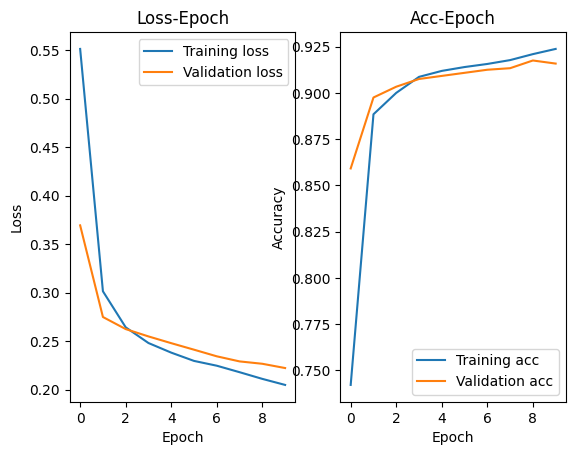

In [10]:
import matplotlib.pyplot as plt
for epoch in range(num_epoch):
    train_loss = 0
    i = 1
    correct_num = 0
    num_batch = 0
    for batch_data in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epoch}"):
      if num_batch < 600:
        model.train() # training mode
        batch_data = to_device(batch_data)
        output = model(**batch_data['batch_inputs'])
        output = output.logits
        loss = loss_fun(output, batch_data['labels'])
        loss.backward()
        train_loss+=loss.item()

        optimizer.step()
        optimizer.zero_grad()# set gradient to 0 when batch is updated


        # if i % 10 == 0: # record every 10 training batches
        #     output = output.argmax(dim=1)
        #     acc = (output == batch_data['labels']).sum().item()/ len(batch_data['labels'])
        #     print(f'Training stage:Batch {i}, Loss: {loss.item()}, Accuracy: {acc}')

        # if i % 30 == 0: # validate every 30 batches
        #     model.eval()
        #     batch_val = next(iter(valid_loader))
        #     with torch.no_grad():
        #         batch_val = to_device(batch_val)
        #         output = model(**batch_val)
        #     val_loss = loss_fun(output, torch.tensor(batch_val['labels']))
        #     output = output.argmax(dim=1)
        #     acc = (output == torch.tensor(batch_val['labels'])).sum().item()/ len(batch_val['labels'])
        #     print(f'Validation stage:Batch {i}, Loss: {loss.item()}, Accuracy: {acc}')

        # i+=1
        num_batch+=1
        output = output.argmax(dim=1)
        correct_num += (output == batch_data['labels']).sum().item()
      else:
        break

    acc = correct_num/(num_batch*batch_size)
    average_loss = train_loss/num_batch
    loss_hists['train'].append(average_loss)
    acc_hists['train'].append(acc)
    print(f"Epoch {epoch + 1}/{num_epoch}, Training Loss: {average_loss:.4f}, Training accuracy: {acc:.4f}")

    # validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct_num = 0
        for i, batch_data in enumerate(valid_loader):
            batch_data = to_device(batch_data)
            output = model(**batch_data['batch_inputs'])
            output = output.logits
            loss = loss_fun(output, batch_data['labels'])
            output = output.argmax(dim=1)

            correct_num += (output == batch_data['labels']).sum().item()
            val_loss+=loss

        acc = correct_num/ (len(valid_loader)*batch_size)
        average_val_loss = val_loss/len(valid_loader)

        loss_hists['val'].append(average_val_loss)
        acc_hists['val'].append(acc)
        print(f'Epoch {epoch + 1}/{num_epoch}, Validation loss: {average_val_loss:.4f}, Validation accuracy: {acc:.4f}')


# draw the loss figures
fig, ax = plt.subplots(1,2)
ax[0].plot(torch.tensor(loss_hists['train']).cpu().detach().numpy()) # can only matplotlib to plot numpy on CPU
ax[0].plot(torch.tensor(loss_hists['val']).cpu().detach().numpy())
ax[0].set_title('Loss-Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(['Training loss', 'Validation loss'])

ax[1].plot(torch.tensor(acc_hists['train']).cpu().detach().numpy())
ax[1].plot(torch.tensor(acc_hists['val']).cpu().detach().numpy())
ax[1].set_title('Acc-Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Training acc', 'Validation acc'])
plt.show()